# Generation and debugging script for the Multi Channel Speech Enhancement Dataset

In [15]:
import numpy as np
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
%reload_ext autoreload
%autoreload 2

## Split the source datas for train and val

In [2]:
# load all clean speeches
clean_root = '/data2/zhouchang/datasets/datasets_fullband/clean_fullband/read_speech'
clean_records = os.listdir(clean_root)
clean_records.sort()
print(len(clean_records))

# split train and val clean speeches set
data_split = {'train':20,'val':1}
n_clean_train = int(len(clean_records)*data_split['train']/sum(data_split.values()))

rs = np.random.RandomState(123)

rs.shuffle(clean_records)
cleans_train = clean_records[:n_clean_train]
cleans_val = clean_records[n_clean_train:]
print(f'clean train:val = {len(cleans_train)}:{len(cleans_val)}')

# load all noises
noise_root = '/data2/zhouchang/datasets/datasets_fullband/noise_fullband'
noise_records = os.listdir(noise_root)
noise_records.sort()
print(len(noise_records))

# split train and val noise speeches set
n_noise_train = int(len(noise_records)*data_split['train']/sum(data_split.values()))

rs.shuffle(noise_records)
noises_train = noise_records[:n_noise_train]
noises_val = noise_records[n_noise_train:]
print(f'noise train:val = {len(noises_train)}:{len(noises_val)}')

# write to files
with open('/data2/zhouchang/datasets/datasets_fullband/cleans_train', 'w') as f:
    for i,x in enumerate(cleans_train):
        if i>0:
            f.write('\n')
        f.write(x)
with open('/data2/zhouchang/datasets/datasets_fullband/noises_train', 'w') as f:
    for i,x in enumerate(noises_train):
        if i>0:
            f.write('\n')
        f.write(x)

65348
clean train:val = 62236:3112
63810
noise train:val = 60771:3039


In [ ]:
fs, clean = wavfile.read(os.path.join(clean_root,cleans_val[0]))
print(fs,clean.dtype)
IPython.display.display(IPython.display.Audio(clean, rate=fs))
fs, noise = wavfile.read(os.path.join(noise_root,noises_val[0]))
IPython.display.display(IPython.display.Audio(noise , rate=fs))

## Sample generation play ground



In [7]:
import json
with open('mcse_dataset_settings.json','r') as f:
    opt = json.load(f)
fs = opt['audio']['fs']

{'room_dim': array([7.60470227, 5.72723158, 2.80344237]), 'e_absorption': 0.25899957142800284, 'max_order': 63, 'fs': 16000, 'p_mics': array([[3.14666449, 3.19361976, 3.18441931, 3.17521886, 3.1660184 ,
        3.1650654 , 3.15586495, 3.13746404],
       [3.8593943 , 3.81148602, 3.84004039, 3.86859475, 3.89714912,
        3.80228557, 3.83083994, 3.88794866],
       [1.45790622, 1.45790622, 1.45790622, 1.45790622, 1.45790622,
        1.45790622, 1.45790622, 1.45790622]]), 'p_target': array([1.35223965, 3.26545635, 1.09181576]), 'p_noise_list': [array([0.34912672, 5.25852753, 1.49750311]), array([1.11501413, 2.00334255, 1.42132674]), array([0.01288007, 4.96287787, 1.31692211])], 'snr_list': [-2.600855218364865, -3.986787310291077, 0.40506293202342203], 'dBFS': -31.89441644090053, 'clean': 'book_08463_chp_0002_reader_01375_21.wav', 'noises': array(['Als5JBBsJP0.wav',
       'squeak_squeakyChair_Freesound_validated_448114_4.wav',
       'Z3w226RP6to.wav'], dtype='<U95')}


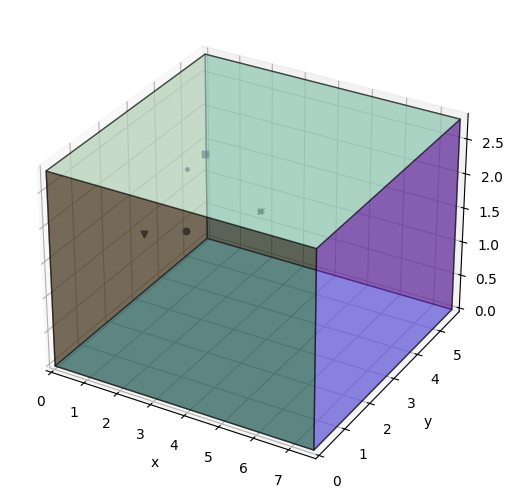

In [19]:

from dataset.mcse_dataset import generate_random_noisy_for_speech
sample = generate_random_noisy_for_speech(opt, 8, cleans_val[0], noises_val, clean_root, noise_root)
meta = sample['meta']
room = sample['room']
freefield = sample['freefield']
noisy = sample['noisy']
clean = sample['clean']
fig, ax = room.plot(img_order=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
print(meta)

(8, 128000)
(128000,)
noisy[0] shape=(128000,)


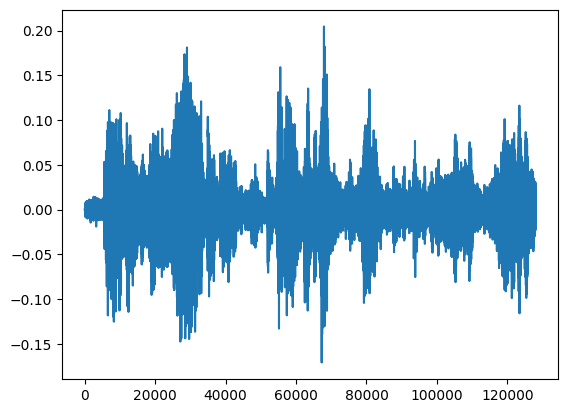

clean shape=(128000,)


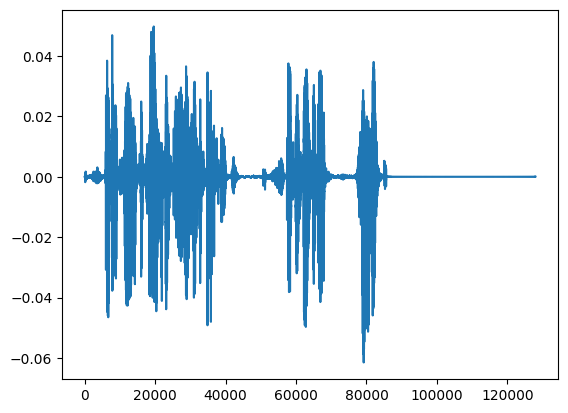

In [20]:
def show_audio(audio,fs,name):
    print(f'{name} shape={audio.shape}')
    plt.plot(audio)
    plt.show()
    IPython.display.display(IPython.display.Audio(audio, rate=fs))
    
# plt.plot(room.rir[0][0])
# plt.show()
# plt.plot(freefield.rir[0][0])
# plt.show()
print(noisy.shape)
print(clean.shape)
show_audio(noisy[0],fs,'noisy[0]')
show_audio(clean,fs,'clean')

In [ ]:

show_audio(clean,fs,'clean')
show_audio(noisy[0],fs,'noisy[0]')
show_audio(noisy[0]-clean,fs,'noisy[0]-clean')


## Generate val samples

We only generate validation samples while training samples are generated online.

In [ ]:
import pickle
from tqdm import tqdm

data_val_root = '/data2/zhouchang/datasets/mcse_val'
if not os.path.exists(data_val_root):
    os.makedirs(data_val_root)
    
noisy_val_root = os.path.join(data_val_root,'noisy')
if not os.path.exists(noisy_val_root):
    os.makedirs(noisy_val_root)
    
clean_val_root = os.path.join(data_val_root,'clean')
if not os.path.exists(clean_val_root):
    os.makedirs(clean_val_root)
    
meta_val_root = os.path.join(data_val_root,'meta')
if not os.path.exists(meta_val_root):
    os.makedirs(meta_val_root)

def write_meta(meta_root,name):
    with open(os.path.join(meta_root,f'{name}.pickle'),'wb') as f:
        pickle.dump(meta,f)

def load_meta(meta_root,name):
    with open(os.path.join(meta_root,f'{name}.pickle'),'rb') as f:
        loaded_meta = pickle.load(f)
    return loaded_meta

def write_audio(audio, fs, path):
    audio = np.clip(audio,-1,1)*np.iinfo(np.int16).max-1
    wavfile.write(path, fs, audio.astype(np.int16))

clip_seconds = 8
print(fs)
for i in tqdm(range(len(cleans_val))):
    clean = cleans_val[i]
    meta, room, freefield, noisy, clean = generate_random_noisy_for_speech(opt, clip_seconds, clean, noises_val, clean_root, noise_root)
    name = f'{i:04}'
    write_meta(meta_val_root,name)
    write_audio(noisy.T,fs,os.path.join(noisy_val_root,f'{name}.wav'))
    write_audio(clean,fs,os.path.join(clean_val_root,f'{name}.wav'))
    

    